# GLOBAL SUPERSTORE DATASET SALES ANALYSIS
By Student ID: 202410472

## 1. Task 1

#### Import required Python Libraries

In [ ]:
# pip install packages
import sys
!{sys.executable} -m pip install word2number
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install adjustText
!{sys.executable} -m pip install gender-guesser

# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import socket
import requests
import geopandas as gpd
import gender_guesser.detector as gender

from matplotlib import ticker as mtick
from tabulate import tabulate
from word2number import w2n
from adjustText import adjust_text

# Letting pandas to show max columns
pd.set_option('display.max_columns', None)

# Set the style for seaborn plots
sns.set_theme(style="whitegrid")

# Gender detector
detector = gender.Detector()

#### Load first 10 records

In [ ]:
# Reading CSV file and assigning into a dataframe ss_data
global_super_store_df_org = pd.read_csv('sample-superstore 2023 T3.csv')

# Copy the dataframe before processing
global_super_store_df = global_super_store_df_org.copy()

# Get the first 1000 records only
global_super_store_df = global_super_store_df.head(n=1000)

# Set the head to 10 to retrieve the first 10 records
first_10_rows = global_super_store_df.head(n=10)
print(tabulate(first_10_rows, headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

### Understanding of the dataset

#### Information of descriptive statistics

Using info() and describe() function to get the descriptive statistics

In [ ]:
# Get the metadata information about the dataset
# Grouping data types by category
numerical_columns = global_super_store_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = global_super_store_df.select_dtypes(include=['object']).columns
datetime_columns = global_super_store_df.select_dtypes(include=['datetime64']).columns

# Define a table width and print the header row with a dotted line
table_width = 250
print("-" * table_width)

# Print each row of the table with content and a dash line
content_list = [f"We are working with a {global_super_store_df.shape} sized dataset.", 
                    f"Numercial columns: {', '.join(numerical_columns)}",
                    f"Categorical columns: {', '.join(categorical_columns)}",
                    f"Date Time columns: {', '.join(datetime_columns)}"]

for content_row in content_list:
    print("| {:<246} |".format(content_row))
    print("-" * table_width)

# Print the table
print(tabulate(global_super_store_df.describe(), headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

In [ ]:
# Print metatype information about the dataset
print(global_super_store_df.info())

#### Missing Data Analysis

In [ ]:
# Count the number of missing values in each column
missing_values_per_column = global_super_store_df.isna().sum()

# Convert the Series to a DataFrame for tabulation
missing_values_df = missing_values_per_column.to_frame().reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

# Print the tabulated missing values per column
print("Number of missing values per column:\n")
print(tabulate(missing_values_df, headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

# Count the total number of missing values across all columns
total_missing_values = missing_values_per_column.sum()

# Print the total number of missing values
print("\nTotal number of missing values:", total_missing_values)

The primary key of these records are a system-generated, and denoted as column: *RowID*

The datatypes of the dataset are following:
* int64(1)
* float64(2)
* object(18)

A few records of *Quantity* and *Profit* columns has the datatype of object, but it must be float64, thus needs to be cleansed or transformed.  

*Ship Date* and *Order Date* columns are represented as strings, those needs to be converted as datetime.

Once cleansed, the descriptive statistics can be applied to the numerial columns, and they are Sales, Quantity, Discount and Profit/Loss.


#### Histograms based on categorical features

In [ ]:
def plot_histogram(data, xlabel, ylabel, title): 
    
    """    
    plot_histogram generates a histogram plot for the given dataset.
    Parameters:
      data: Dataset for the histogram plot (pandas Series or any iterable).
      xlabel: Label for the x-axis.
      ylabel: Label for the y-axis.
      title: Title of the plot.
    Returns: None
    
    """
    
    plt.figure(figsize=(12, 10)) 

    bars = plt.bar(data.index, data)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    plt.show()

In [ ]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts(ascending=True)
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

The plot_histogram() function can be run after the data cleansing.

## 2. Task 2

### Handling missing values in the dataset

* Before performing any statistical analysis, the numerical column data has to be cleansed to be meaningful.
* Dropping unnecessary columns.
* Records with special characters on Quantity and needs to be cleansed. 
* Records with special characters on **Profit** and needs to be cleansed.
* Applying the **w2n** library to fix **Quantity** and **loss** columns and convert them into float64 dtype.
* City and States are missing on a few records, **get_city_from_postal_code()** and **get_state_from_postal_code()** functions will fix them via API.
* **Category** and **Sub-Category** needs cleansing and reorganizing.
* Order Date and Ship Date is jumbled between dd-mm-yyyy, and mm-dd-yyyy formats.
* New columns to perform EDA.

#### Helper functions

In [ ]:
def convert_alphabetic_to_float(df, numerical_feature):
    """
    Convert alphabetic values in a DataFrame column to numbers and update the DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the column to be processed.
        numerical_feature (str): The name of the column containing the values to be converted.

    Returns:
        None. The function modifies the input DataFrame in place.
    """
    
    # Create alphabetic filter using regex
    alphabetic_filter = df[numerical_feature].str.contains(r'^[a-zA-Z]+$', na=False)
    alphabetic_filtered_df = df.loc[alphabetic_filter]

    # Convert alphabetic values to numbers using w2n.word_to_num library
    alphabetic_filtered_df.loc[:, numerical_feature] = alphabetic_filtered_df[numerical_feature].apply(w2n.word_to_num)

    # Update the original DataFrame with the filtered results
    df.update(alphabetic_filtered_df)

    # Convert the column to float
    df[numerical_feature] = df[numerical_feature].astype(float)

In [ ]:
def is_internet_connected():
    """
    Check if the machine is connected to the internet by attempting to connect to Google's DNS server.
    Returns:
        bool: True if the machine is connected to the internet, False otherwise.
    """
    try:
        # Attempt to connect to Google's DNS server
        socket.create_connection(("8.8.8.8", 53), timeout=3)
        return True
    except OSError:
        pass
    return False

In [ ]:
def get_city_from_postal_code(postal_code):
    """
    get_city_from_postal_code retrieves the city name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the city.
    Returns:
        str or None: City name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """
    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        city = data['places'][0]['place name']
        return city
    else:
        return None

In [ ]:
def get_state_from_postal_code(postal_code):
    """
    get_state_from_postal_code retrieves the state name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the state.
    Returns:
        str or None: State name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """

    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        state = data['places'][0]['state']
        return state
    else:
        return None

In [ ]:
def format_date_in_yyyymmdd(date_str):
    """
    Formats a date string to the format 'yyyy-mm-dd'.

    Parameters:
    - date_str (str or pd.NA): A string representing a date.

    Returns:
    - str or pd.NA: The standardized date string in 'yyyy-mm-dd' format, or pd.NA if input is blank or NaN.
    """
    if pd.notna(date_str) and date_str.strip():  # Check if date is not blank or NaN
        try:
            # Attempt to parse as yyyy-mm-dd with dayfirst=False
            return pd.to_datetime(date_str, dayfirst=False, errors='coerce').strftime('%Y-%m-%d')
        except ValueError:
            # If parsing fails, attempt to parse as dd-mm-yyyy
            return pd.to_datetime(date_str, format='%d-%m-%Y', errors='coerce').strftime('%Y-%m-%d')
    else:
        return date_str  # Return the original blank or NaN value

In [ ]:
def guess_gender(full_name):
    """
    Guesses the gender based on the provided full name.

    Parameters:
    - full_name (str or pd.NA): The full name of the person.

    Returns:
    - str: The guessed gender ('Male', 'Female', or 'Unknown').
    """
    if pd.notna(full_name):  # Check if the value is not NaN
        parts = full_name.split()
        if len(parts) > 1:  # Check if the name contains a space
            first_name, last_name = parts[:2]  # Split into first name and last name
            first_gender = detector.get_gender(first_name)
            last_gender = detector.get_gender(last_name)

            # If either part indicates male, return Male
            if first_gender == 'male' or last_gender == 'male':
                return 'Male'
            # If either part indicates female, return Female
            elif first_gender == 'female' or last_gender == 'female':
                return 'Female'
            # If neither part indicates a gender, return Unknown
            else:
                return 'Unknown'
        else:
            # Only one name provided, guess gender based on it
            single_name_gender = detector.get_gender(full_name.split()[0])
            if single_name_gender == 'male':
                return 'Male'
            elif single_name_gender == 'female':
                return 'Female'
            else:
                return 'Unknown'
    else:
        return 'Unknown'  # Return 'Unknown' for NaN values


#### Dropping unwanted columns

In [ ]:
# Columns to drop
columns_to_drop = ['Row ID', 'Order ID', 'Customer ID', 'Product ID', 'Product Name']

# Row ID is not needed for the analysis, hence dropping the column
global_super_store_df.drop(columns=columns_to_drop, inplace=True)

#### Replacing faulty values

In [ ]:
# Removing "?" from Quantity column
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].str.replace('?', '')

# Removing """ from loss column
global_super_store_df['loss'] = global_super_store_df['loss'].str.replace('"', '')

# Removing """ from Postal Code column
global_super_store_df['Postal Code'] = global_super_store_df['Postal Code'].str.replace('"', '')

# Make all records as Country = United States
global_super_store_df['Country'] = 'United States'

# Correcting spelling mistakes on Category column
global_super_store_df['Category'] = global_super_store_df['Category'].replace('Frnture', 'Furniture')

# Datafix on Category based on subcategories
# Apply the condition element-wise
condition = (global_super_store_df['Category'] == 'NO_CATEGORY') & \
            (global_super_store_df['Sub-Category'].isin(['Binders', 'Storage']))

# Update 'Category' where the condition is True
global_super_store_df.loc[condition, 'Category'] = 'Office Supplies'

# Update empty and wrong records on Segment Column
global_super_store_df['Segment'] = global_super_store_df['Segment'].replace('%', 'NO_SEGMENT')

# Cleanse the Regions
central_regions_to_replace = ['Centrl', 'Cntral']
east_regions_to_replace = ['Est']
south_regions_to_replace = ['Southh']

global_super_store_df['Region'] = global_super_store_df['Region'].replace(central_regions_to_replace, 'Central')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(east_regions_to_replace, 'East')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(south_regions_to_replace, 'South')

# Cleanse the Order Date column
global_super_store_df['Order Date'] = global_super_store_df['Order Date'].str.replace('$April', '')

# Cleanse the Customer Name column
global_super_store_df['Customer Name'] = global_super_store_df['Customer Name'].str.replace('10', 'NONE')

#### Filling empty values with default values

In [ ]:
# Filling values on empty Customer Name records
global_super_store_df['Customer Name'] = global_super_store_df['Customer Name'].fillna('NO_CUSTOMER_NAME')

# Assuming zero values for NaN on losss
global_super_store_df['loss'] = global_super_store_df['loss'].fillna(0.00)

# Filling values on empty Category and Sub-Category records
global_super_store_df['Category'] = global_super_store_df['Category'].fillna('NO_CATEGORY')
global_super_store_df['Sub-Category'] = global_super_store_df['Sub-Category'].fillna('NO_SUB_CATEGORY')

# Filling Quantity as 1 as sold quantity cannot be zero
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].fillna(1.00)

# Filling Discount as 0
global_super_store_df['Discount'] = global_super_store_df['Discount'].fillna(0.00)

# Filling Sales as 0
global_super_store_df['Sales'] = global_super_store_df['Sales'].fillna(0.00)

# Filling values on empty Ship Mode records
global_super_store_df['Ship Mode'] = global_super_store_df['Ship Mode'].fillna('NO_SHIP_MODE')

# Filling values on empty Postal Code records
global_super_store_df['Postal Code'] = global_super_store_df['Postal Code'].fillna('NO_POSTAL_CODE')

# Filling values on empty Region records
global_super_store_df['Region'] = global_super_store_df['Region'].fillna('NO_REGION')

# Filling values on empty Segment records
global_super_store_df['Segment'] = global_super_store_df['Segment'].fillna('NO_SEGMENT')

#### Applying helper functions to fill the data

In [ ]:
# Filter the empty state rows
state_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['State'])]
state_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['State']), 'State'] = state_filtered_na['Postal Code'].apply(get_state_from_postal_code)

In [ ]:
# Filter the empty city rows
city_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['City'])]
city_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['City']), 'City'] = city_filtered_na['Postal Code'].apply(get_city_from_postal_code)

In [ ]:
# Call the function to convert the the Quantity and loss columns which has alphabetic values and convert them to float
convert_alphabetic_to_float(global_super_store_df, 'Quantity')
convert_alphabetic_to_float(global_super_store_df, 'loss')

In [ ]:
# Guessing the gender of the Customer
global_super_store_df['Gender'] = global_super_store_df['Customer Name'].apply(guess_gender)

#### Order Date / Ship Date fixes

In [ ]:
# Get the all the records out of that filter to fix
date_fix_condition = (~global_super_store_df['Ship Date'].isna()) & \
                            (~global_super_store_df['Order Date'].isna())

# Standardize Order Date column
global_super_store_df.loc[date_fix_condition, 'Order Date'] = global_super_store_df.loc[date_fix_condition, 'Order Date'].apply(format_date_in_yyyymmdd)

# Standardize Ship Date column
global_super_store_df.loc[date_fix_condition, 'Ship Date'] = global_super_store_df.loc[date_fix_condition, 'Ship Date'].apply(format_date_in_yyyymmdd)

# Swap Order Date and Ship Date if necessary
for index, row in global_super_store_df.iterrows():
    order_date = pd.to_datetime(row['Order Date'], errors='coerce')  # Coerce errors to NaT for comparison
    ship_date = pd.to_datetime(row['Ship Date'], errors='coerce')  # Coerce errors to NaT for comparison
    
    if not pd.isna(order_date) and not pd.isna(ship_date) and order_date > ship_date:
        global_super_store_df.at[index, 'Order Date'], global_super_store_df.at[index, 'Ship Date'] = row['Ship Date'], row['Order Date']

In [ ]:
# Convert columns to datetime64 dtype
global_super_store_df['Order Date'] = pd.to_datetime(global_super_store_df['Order Date'], format='mixed')
global_super_store_df['Ship Date'] = pd.to_datetime(global_super_store_df['Ship Date'], format='mixed')

# Filling 01/01/1970 date as a NO_DATA_DATE date
global_super_store_df['Order Date'] = global_super_store_df['Order Date'].fillna('1970/01/01')
global_super_store_df['Ship Date'] = global_super_store_df['Ship Date'].fillna('1970/01/01')

#### New columns to Analyze

After cleansing the data, the following columns have been added to perform EDA and visualizations.

| Column Name   | Data Type | Description                                                                   |
| ------------  | --------- |-------------------------------------------------------------------------------|
| Loss          | float64   | Negative losss will be marked as loss                                       |   
| Shipment Days | float64   | Calculate the days between Order Date and Shipped Date                        |                                         
| Order Year    | int32     | Extracted year from Order Date to plot the sales/loss trends                |
| Ship Year     | int32     | Extracted year from Ship Date to plot the sales/loss trends                 |                       
| Gender        | object    | Experimenting to guess the gender of the customer to perform gender analysis  |                                      

In [ ]:
# New column Shipment Days
global_super_store_df['Shipment Days'] = (global_super_store_df['Ship Date'] - global_super_store_df['Order Date']).dt.days

# New columns: Order Year and Ship Year. extract year from 'Order Date' and 'Ship Date' columns
global_super_store_df['Order Year'] = pd.DatetimeIndex(global_super_store_df['Order Date']).year
global_super_store_df['Ship Year'] = pd.DatetimeIndex(global_super_store_df['Ship Date']).year

# Fill NaN values with 0 (assuming missing years should be represented as 0)
global_super_store_df[['Order Year', 'Ship Year']] = global_super_store_df[['Order Year', 'Ship Year']].fillna(0)

# Convert year columns to integer dtype
global_super_store_df[['Order Year', 'Ship Year']] = global_super_store_df[['Order Year', 'Ship Year']].astype(int)

# New column 'Loss' where loss is negative
global_super_store_df['Loss'] = global_super_store_df['loss'].apply(lambda x: -x if x < 0 else 0)

#### Plotting histograms after cleansing data

In [ ]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts(ascending=True)
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

### Descriptive statistics

In [ ]:
# Descriptive Statistics
descriptive_stats = global_super_store_df.describe().round(2)

# Generate descriptive statistics
print(tabulate(descriptive_stats, headers='keys', tablefmt='pretty', stralign ='right', showindex=True))

In [ ]:
# Calculate the number of missing values for each column
missing_values = global_super_store_df.isnull().sum().to_frame(name='Missing Value Count')

# Display the missing values using tabulate
print(tabulate(missing_values, headers='keys', tablefmt='pretty', stralign='right', showindex=True))

### Grouping of data

#### Grouping Sales/Losses based on Categories

In [ ]:
def print_unique_values_on_tabulate(df, column_name):
    """
    print_unique_values_on_tabulate, prints unique values from a specified column of a DataFrame in a table format.

    Parameters:
    - df (DataFrame): The DataFrame from which unique values will be extracted.
    - column_name (str): The name of the column from which unique values will be extracted.

    Returns:
    - None
    """
    # Get unique values from the specified column
    unique_values = df[column_name].unique()
    
    # Flatten unique values array
    flat_unique_values_array = unique_values.flatten()
    
    # Convert flattened array to list of lists
    data = [[item] for item in flat_unique_values_array]
    
    # Set Header
    header = [f'Unique {column_name.capitalize()}']
    
    # Print the table using tabulate
    print(tabulate(data, headers=header, tablefmt='pretty', stralign ='left', showindex=False))

In [ ]:
print_unique_values_on_tabulate(global_super_store_df, 'Category')

In [ ]:
def print_sales_loss_by_feature(df, feature_column, category_column):
    """
    print_sales_loss_by_feature, prints total sales/loss by category in a tabular format.

    Parameters:
    - df (DataFrame): The DataFrame containing the sales data.
    - sales_column (str): The name of the column containing sales data.
    - sales_category_column (str): The name of the column to group by.

    Returns:
    - None
    """
    # Group total sales by category
    sales_category = df.groupby(category_column)[feature_column].sum().round(4).reset_index().sort_values(by=feature_column, ascending=False)
    
    # Convert the grouped DataFrame to a list of lists
    sales_category_list = sales_category.values.tolist()

    # Print the table using tabulate
    print(tabulate(sales_category_list, headers=[category_column, f'Total {feature_column}'], tablefmt='pretty', stralign ='left'))

In [ ]:
# group total sales by category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Sales', 'Category')

In [ ]:
# group total loss by category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Loss', 'Category')

In [ ]:
# group total sales by category, only considering sales
sales_category = global_super_store_df.groupby('Category')['Sales'].sum()

# group total loss by category, only considering losses
loss_category = global_super_store_df.groupby('Category')['Loss'].sum()

# figure size
plt.figure(figsize=(15,10));

# left total sales pie chart
plt.subplot(1,2,1); # 1 row, 2 columns, the 1st plot.
plt.pie(sales_category.values, labels=sales_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(sales_category.values) / 100 :,.2f}', 
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Sales by Category',  fontdict={'fontsize':16});

# right total loss pie chart
plt.subplot(1,2,2); # 1 row, 2 columns, the 2nd plot
plt.pie(loss_category.values, labels=loss_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(loss_category.values) / 100 :,.2f}',
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Loss by Category', fontdict={'fontsize':16});

 > _Total Sales on Categories_

1. Furniture at ~53% 
2. Technology at ~27%
3. Office Supplies at ~20%



 > _Total Losses on Categories_

1. Technology at ~39%
2. Office Supplies at ~36%
3. Technology at ~26%


#### Grouping Sales/Losses based on Sub-Categories

In [ ]:
print_unique_values_on_tabulate(global_super_store_df, 'Sub-Category')

In [ ]:
# group total sales by sub-category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Sales', 'Sub-Category')

In [ ]:
# group total loss by sub-category from the highest loss.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Loss', 'Sub-Category')

In [ ]:
#Grouping the data on category and it's respective sub-categories. Calculating the loss margin.
sales_per_cat_subcat = global_super_store_df.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Loss']].sum()
sales_per_cat_subcat['Loss %'] = (sales_per_cat_subcat['Loss'] / sales_per_cat_subcat['Sales']) * 100

#Sorting the dataframe based on loss margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Loss %'], ascending=False)
print(tabulate(sales_per_cat_subcat.round(2), headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

#### Grouping Sales/Losses based on States

In [ ]:
# group total sales by states from the highest sale.
sales_by_states = global_super_store_df.groupby(['State'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_states['Sales %'] = (sales_by_states['Sales'] / global_super_store_df['Sales'].sum()) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_states.select_dtypes(include='number').columns:
    sales_by_states[numerical_column] = sales_by_states[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_states.round(2), headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

**State made the highest sales %:** Texas \
**State made the lowest sales %:** Connecticut

#### Grouping Sales/Losses based on Segment

In [ ]:
# group total sales by segments from the highest sale.
sales_by_segment = global_super_store_df.groupby(['Segment'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_segment['Sales %'] = (sales_by_segment['Sales'] / global_super_store_df['Sales'].sum()) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_segment.select_dtypes(include='number').columns:
    sales_by_segment[numerical_column] = sales_by_segment[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_segment.round(2), headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

**Consumer** Segment has 50% of Sales share, followed by **Corporate** and **Home Office**.

#### Grouping Sales/Losses based on Shipping Mode

In [ ]:
# group total sales by segments from the highest sale.
sales_by_ship_mode = global_super_store_df.groupby(['Ship Mode'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_ship_mode['Sales %'] = (sales_by_ship_mode['Sales'] / global_super_store_df['Sales'].sum()) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_segment.select_dtypes(include='number').columns:
    sales_by_ship_mode[numerical_column] = sales_by_ship_mode[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_ship_mode.round(2), headers='keys', tablefmt='pretty', stralign ='left', showindex=False))

**Standard** shipping method is preferred as the sales percentage is nearly 64%, followed by **Second Class** and **First Class**. 
**Same Day** is not an economical option, so only preferred by 6% of the orders.

In [ ]:
# Filter the filler date 01/01/1970 - the default NO_DATA date
global_super_store_df_date_filtered = global_super_store_df[(global_super_store_df['Order Date'] != pd.to_datetime('01/01/1970')) & (global_super_store_df['Ship Date'] != pd.to_datetime('01/01/1970'))].groupby('Ship Mode')['Shipment Days'].mean()
grouped_data = global_super_store_df_date_filtered.round(3).reset_index().values.tolist()

print(tabulate(grouped_data, headers=['Ship Mode', 'Average Shipped in Days'], tablefmt='pretty', stralign ='right', showindex=False))

* **Standard Class** shipping method takes ~5 days to ship from the order date.
* **First Class** and **Second Class** are between 2-3 days. 
* **Same Day** is as promised, the orders are shipped with a day.

In conclusion, **Second Class** ship mode is the best value for money, being economical than **First Class** and faster than **Standard Class**.

### Univariate analysis and visualisation

#### Histograms

In [ ]:
def plot_histogram_density(df, column, xlim=None):
    """
    Plot histogram with density plot for a specified column in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.
    column (str): Name of the column to plot.
    xlim (tuple): Tuple containing the lower and upper limits of the x-axis.

    Returns:
    None
    """
    # Create subplots for each column
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot histogram with density plot
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')

    # Set x-axis limits if specified
    if xlim:
        plt.xlim(xlim)

    # Show the plot
    plt.show()

In [ ]:
plot_histogram_density(global_super_store_df, 'Sales', xlim=(0, 2500))
plot_histogram_density(global_super_store_df, 'Quantity')
plot_histogram_density(global_super_store_df, 'Discount')
plot_histogram_density(global_super_store_df, 'Loss', xlim=(-100, 100))

#### PDF/CDF

In [ ]:
# Normalize all columns in the DataFrame
numerical_columns = global_super_store_df.select_dtypes(include=['int64', 'float64']).columns
normalized_df = (global_super_store_df[numerical_columns] - global_super_store_df[numerical_columns].mean()) / global_super_store_df[numerical_columns].std()

# Create subplots for each column
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot PDF and CDF for Sales
sns.kdeplot(normalized_df['Sales'], cumulative=False, ax=axes[0, 0], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Sales'], cumulative=True, ax=axes[0, 0], color='red', label='CDF')
axes[0, 0].set_title('PDF and CDF for Sales')
axes[0, 0].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[0, 0].set_xlim(0, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Quantity
sns.kdeplot(normalized_df['Quantity'], cumulative=False, ax=axes[0, 1], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Quantity'], cumulative=True, ax=axes[0, 1], color='red', label='CDF')
axes[0, 1].set_title('PDF and CDF for Quantity')
axes[0, 1].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[0, 1].set_xlim(0, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Discount
sns.kdeplot(normalized_df['Discount'], cumulative=False, ax=axes[1, 0], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Discount'], cumulative=True, ax=axes[1, 0], color='red', label='CDF')
axes[1, 0].set_title('PDF and CDF for Discount')
axes[1, 0].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[1, 0].set_xlim(0, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Loss
sns.kdeplot(normalized_df['Loss'], cumulative=False, ax=axes[1, 1], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Loss'], cumulative=True, ax=axes[1, 1], color='red', label='CDF')
axes[1, 1].set_title('PDF and CDF for Loss')
axes[1, 1].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[1, 1].set_xlim(0, 3)  # Set custom x-axis limits

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Box plots

In [ ]:
def plot_box_with_mean(df, column):
    """
    Plot box plot with mean marked for a specified column in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.
    column (str): Name of the column to plot.

    Returns:
    None
    """
    # Create a box plot with mean marked
    plt.figure(figsize=(12, 10))
    sns.boxplot(x=df[column], showfliers=False, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'blue', 'markeredgecolor': 'blue'}, medianprops={'color': 'red'})
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.show()

    # Create a box plot with mean marked with Outliers
    plt.figure(figsize=(12, 10))
    sns.boxplot(x=df[column], showfliers=True, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'blue', 'markeredgecolor': 'blue'}, medianprops={'color': 'red'})
    plt.title(f'Box plot of {column} with Outliers')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.show()

In [ ]:
plot_box_with_mean(global_super_store_df, 'Sales')
plot_box_with_mean(global_super_store_df, 'Loss')
plot_box_with_mean(global_super_store_df, 'Quantity')
plot_box_with_mean(global_super_store_df, 'Discount')

#### Violin plots

In [ ]:
def plot_violin(df, column):
    """
    Plot a violin plot for a specified column in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.
    column (str): Name of the column to plot.

    Returns:
    None
    """
    # Create a violin plot
    plt.figure(figsize=(12, 10))
    sns.violinplot(x=df[column])
    plt.title(f'Violin plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.show()

In [ ]:
plot_violin(global_super_store_df, 'Sales')
plot_violin(global_super_store_df, 'Loss')
plot_violin(global_super_store_df, 'Quantity')
plot_violin(global_super_store_df, 'Discount')

In [ ]:
def plot_trend(df, numerical_column, display_dollar_sign=False):
    """
    plot_trend, generates a trend plot for a specified column in a DataFrame, showing the total value of the column over the years.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_column (str): The name of the column for which the trend plot is to be generated.
    - display_dollar_sign (bool): Whether to display y-axis values with a dollar sign ($) prefix. Default is False.

    Returns:
    None
    """
    
    # Filter out rows with 'Order Year' greater than 0
    trend_data = df[df['Order Year'] > 1970]
    # Group by 'Order Year' and calculate the sum of the specified column
    trend_data = trend_data.groupby('Order Year')[numerical_column].sum()

    # Create the plot
    fig, ax = plt.subplots(figsize=(15,10))

    # Plot the bar plot
    bars = ax.bar(x=trend_data.index, height=trend_data.values, color='teal')

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        if display_dollar_sign:
            ax.annotate('$ {:,.2f}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        else:
            ax.annotate('{:,.2f}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Plot the line plot
    ax.plot(trend_data.index, trend_data.values, color='orange')

    # Turn off scientific notation for y-axis
    ax.yaxis.get_major_formatter().set_scientific(False)

    # Set title and labels
    plt.title(f'{numerical_column} trend over the years', fontsize=22)
    plt.ylabel(f'Total {numerical_column}', fontsize=14)
    plt.xlabel('Year', fontsize=14)

    # Convert 'Order Year' column to a list of integers
    years = trend_data.index.tolist()

    # Set x-ticks to only include specific years
    plt.xticks(years, rotation=45)

    # Add gridlines
    plt.grid(axis='x')

    # Show the plot
    plt.show()


### Descriptive statistics

In [ ]:
# Call the function for sales
plot_trend(global_super_store_df, 'Sales', display_dollar_sign=True)

# Call the function for quantities
plot_trend(global_super_store_df, 'Quantity', display_dollar_sign=False)

# Call the function for loss
plot_trend(global_super_store_df, 'Loss', display_dollar_sign=True)

# Call the function for discounts
plot_trend(global_super_store_df, 'Discount', display_dollar_sign=True)


### Correlation 

In [ ]:
#Select Numerical Features
numerical_features = ['Sales', 'Quantity', 'Discount', 'Loss']
global_super_store_numerial_data = global_super_store_df[numerical_features]

# Create Correlation matrix
correlation_matrix = global_super_store_numerial_data.corr()
print(tabulate(correlation_matrix.round(4), headers='keys', tablefmt='pretty', stralign ='right', showindex=True))

# Plot correlation matrix as heatmap
sns.heatmap(correlation_matrix.round(4), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


| Numercial Feature     | Correlation Coefficient| Correlation Defined As       | Directionality |
| :----------------     | ----------------------:| ----------------------------:| --------------:|                  
| Sales Vs. Loss        | 0.50                   | moderate strength of positive| Same           |  
| Sales Vs. Discount    | -0.13                  | weak negative                | Opposite       |  
| Sales Vs. Quantity    | 0.16                   | weak positive                | Same           |      
| Quantity Vs. Loss     | 0.12                   | weak positive                | Same           |      
| Quantity Vs. Discount | 0.14                   | weak positive                | Same           |      
| Discount Vs. Loss     | 0.17                   | weak positive                | Same           |      

Sales and Loss has a moderate positive correlation, when one increases, it tend to increase the other one. 
The positive correlation however does not imply causation. Meaning that Sales does not influence Loss to incurr and vice-versa.

The other correlations are weak negative / positive. We cannot make concrete decisions, especially caustions.


### Outlier Treatment

##### Interquartile Range (IQR) Method

In [ ]:
def detect_plot_outliers_iqr(df, numerical_feature):
    """
    Plots a boxplot for the specified numerical feature and identifies outliers based on the interquartile range (IQR).

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        numerical_feature (str): The name of the numerical feature to analyze.

    Returns:
        None
    """

    q1 = df[numerical_feature].quantile(0.25)
    q3 = df[numerical_feature].quantile(0.75)

    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    outliers_df = df[(df[numerical_feature] < lower_limit)|(df[numerical_feature] > upper_limit)]
    print(f"Outlier numerical feature: {numerical_feature}, Outlier Count: {outliers_df[numerical_feature].count()}")
    
    numerical_column = df[numerical_feature]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=numerical_column)
    plt.title(f'Boxplot of Outliers for {numerical_feature}')
    plt.show()

In [ ]:
detect_plot_outliers_iqr(global_super_store_df, 'Sales')
detect_plot_outliers_iqr(global_super_store_df, 'Quantity')
detect_plot_outliers_iqr(global_super_store_df, 'Discount')
detect_plot_outliers_iqr(global_super_store_df, 'Loss')
detect_plot_outliers_iqr(global_super_store_df, 'Shipment Days')

##### Z-Score Method

In [ ]:
def detect_outliers_zscore(df, numerical_feature, threshold=3):
    """
    Detect outliers in a numerical feature of a DataFrame using the Z-Score method.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        numerical_feature (str): The name of the numerical feature to analyze.
        threshold (float): The Z-Score threshold for identifying outliers. Default is 3.

    Returns:
        None
    """
    data = df[numerical_feature]
    z_scores = ((data - data.mean()) / data.std()).abs()
    outliers = z_scores > threshold
    outlier_count = outliers.sum()
    print(f"Outlier count for {numerical_feature}: {outlier_count}")

In [ ]:
detect_outliers_zscore(global_super_store_df, 'Sales')
detect_outliers_zscore(global_super_store_df, 'Quantity')
detect_outliers_zscore(global_super_store_df, 'Discount')
detect_outliers_zscore(global_super_store_df, 'Loss')
detect_outliers_zscore(global_super_store_df, 'Shipment Days')

## 3. Task 3

### Two categorical variables

#### Helper functions to plot bivariate analysis and visualization

Function: categorical_analysis() uses cross-tabulation to plot heatmaps/stacked bar plots 

In [ ]:
def categorical_analysis(df, cat_var1, cat_var2):
    """
    Perform bivariate analysis and visualization between two categorical variables.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        cat_var1 (str): Name of the first categorical variable.
        cat_var2 (str): Name of the second categorical variable.
    """
    
    # Cross-tabulation
    cross_tab = pd.crosstab(df[cat_var1], df[cat_var2])

    # Visualize cross-tabulation using a heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Cross-tabulation between {cat_var1} and {cat_var2}')
    plt.xlabel(cat_var2)
    plt.ylabel(cat_var1)
    plt.show()

    # Stacked bar plot for better visualization
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Stacked Bar Plot of {cat_var1} by {cat_var2}')
    plt.xlabel(cat_var1)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=cat_var2)
    plt.show()

Function: bivariate_categorical_sales_figure_analysis() uses pivot tables to plot heatmaps/stacked bar plots 

In [ ]:
def bivariate_categorical_figure_analysis(df, cat_var1, cat_var2, numerical_feature):
    """
    Perform bivariate analysis and visualization between two categorical variables based on a numerical feature.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        cat_var1 (str): Name of the first categorical variable.
        cat_var2 (str): Name of the second categorical variable.
    """
    # Create a pivot table with 'Sales' values
    pivot_table = df.pivot_table(values=numerical_feature, index=cat_var1, columns=cat_var2, aggfunc='sum', fill_value=0)
    
    # Define color palette
    color_palette = sns.color_palette("YlGnBu")
    
    # Plotting the pivot table
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_table, annot=True, cmap=color_palette, fmt=',.2f')
    plt.title(f'Cross-tabulation of Total {numerical_feature} between {cat_var1} and {cat_var2} in USD')
    plt.xlabel(cat_var2)
    plt.ylabel(cat_var1)
    plt.show()

    # Plotting the pivot table as a stacked bar plot
    ax = pivot_table.plot(kind='bar', stacked=True, figsize=(9, 6), color=color_palette)
    ax.set_title(f'Stacked Bar Plot of Total {numerical_feature} by {cat_var1} and {cat_var2}')
    ax.set_xlabel(cat_var1)
    ax.set_ylabel(f'Total {numerical_feature}')
    ax.set_xticklabels(pivot_table.index, rotation=45)
    
    # Format y-axis tick labels as currency
    ax.yaxis.set_major_formatter('$ {:,.2f}'.format)
    
    ax.legend(title=cat_var2)
    plt.show()

#### Segment Vs. Ship Mode

In [ ]:
categorical_analysis(global_super_store_df, 'Segment', 'Ship Mode')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Segment', 'Ship Mode', 'Sales')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Segment', 'Ship Mode', 'Loss')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Segment', 'Ship Mode', 'Discount')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Category', 'Ship Mode', 'Sales')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Category', 'Ship Mode', 'Sales')

#### Segment Vs. Ship Mode

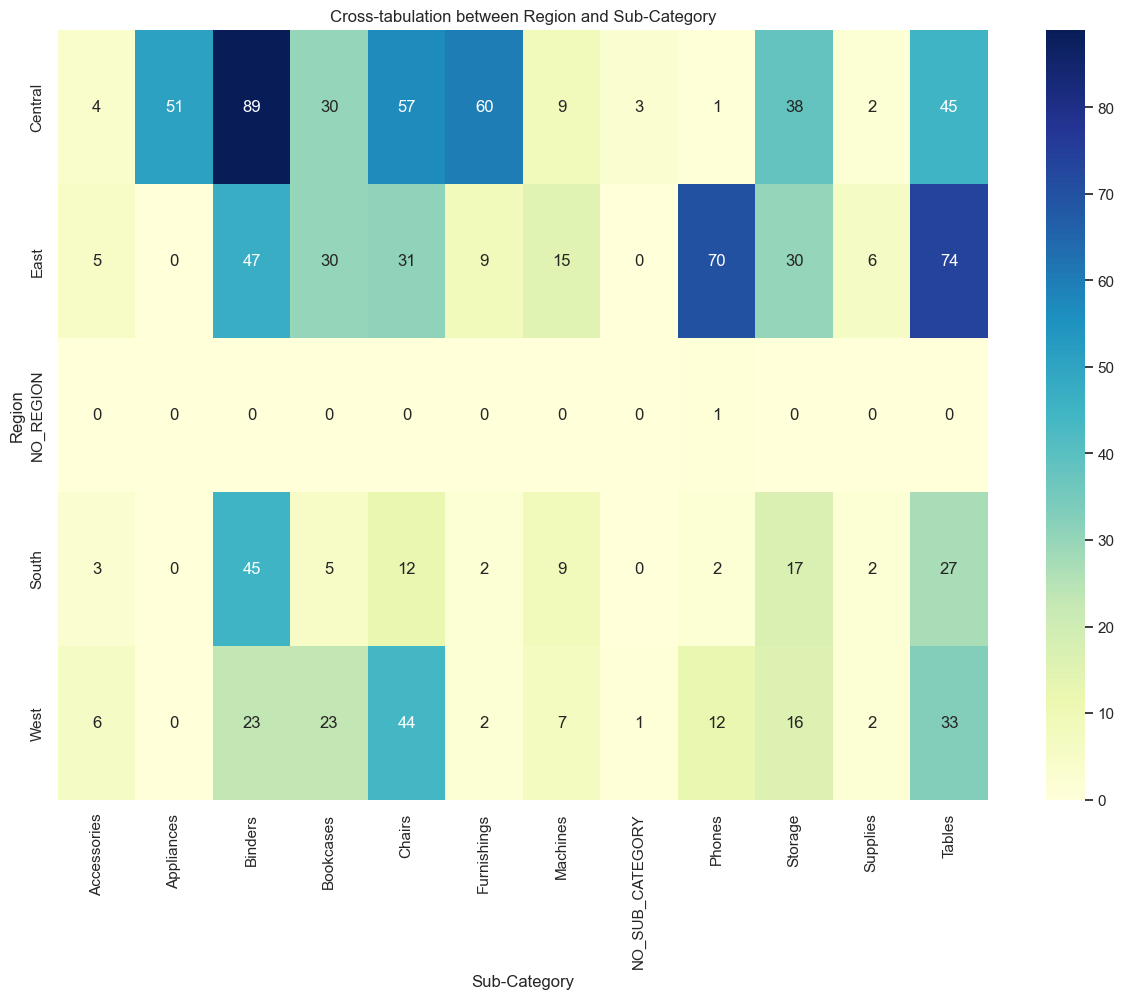

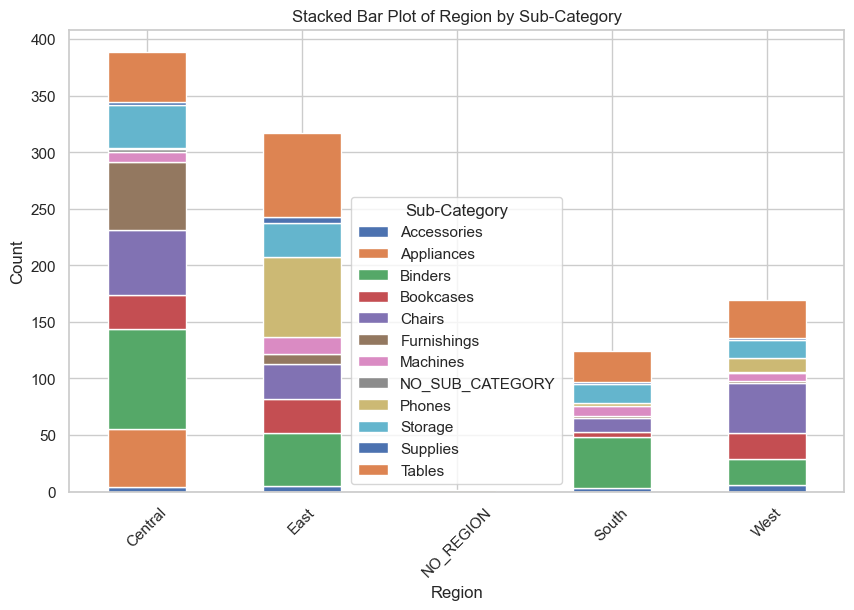

In [828]:
categorical_analysis(global_super_store_df, 'Region', 'Sub-Category')

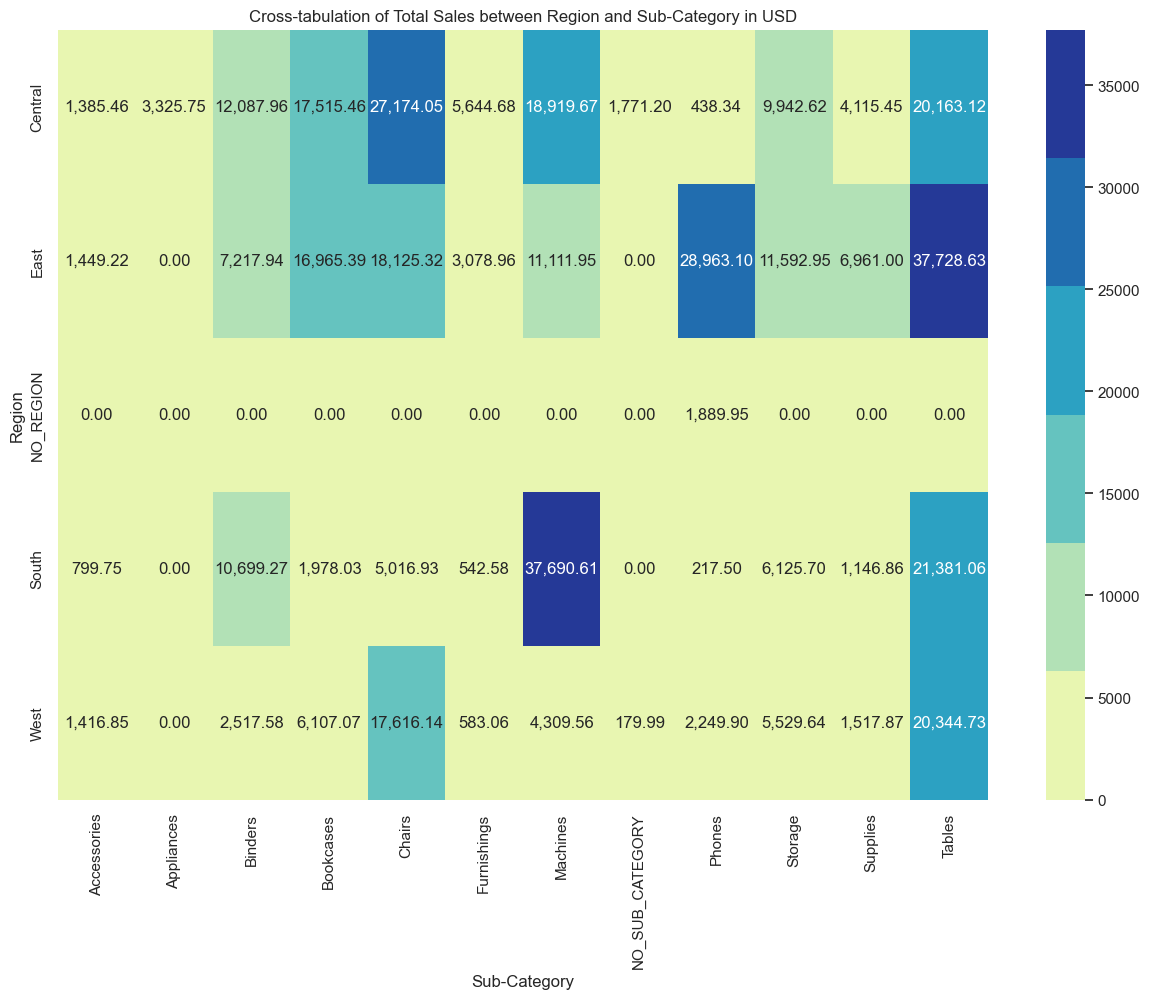

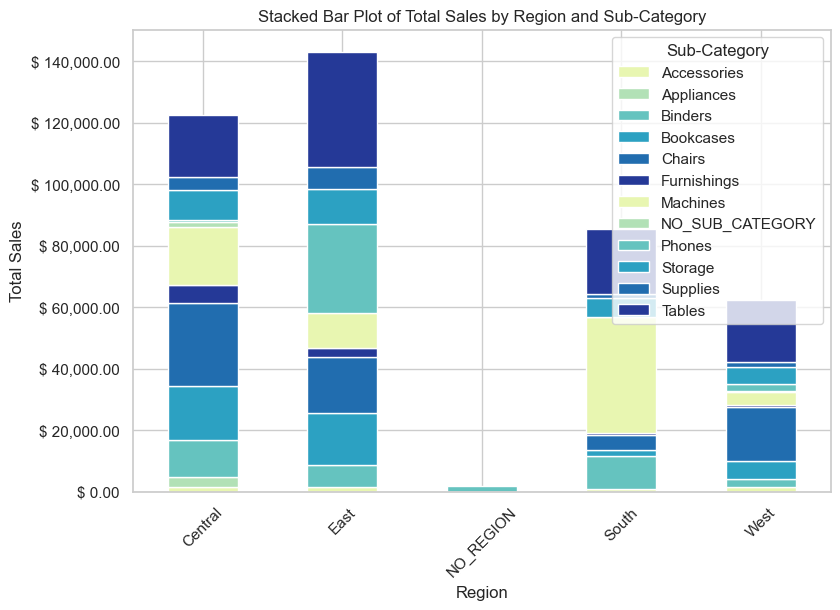

In [829]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Sales')

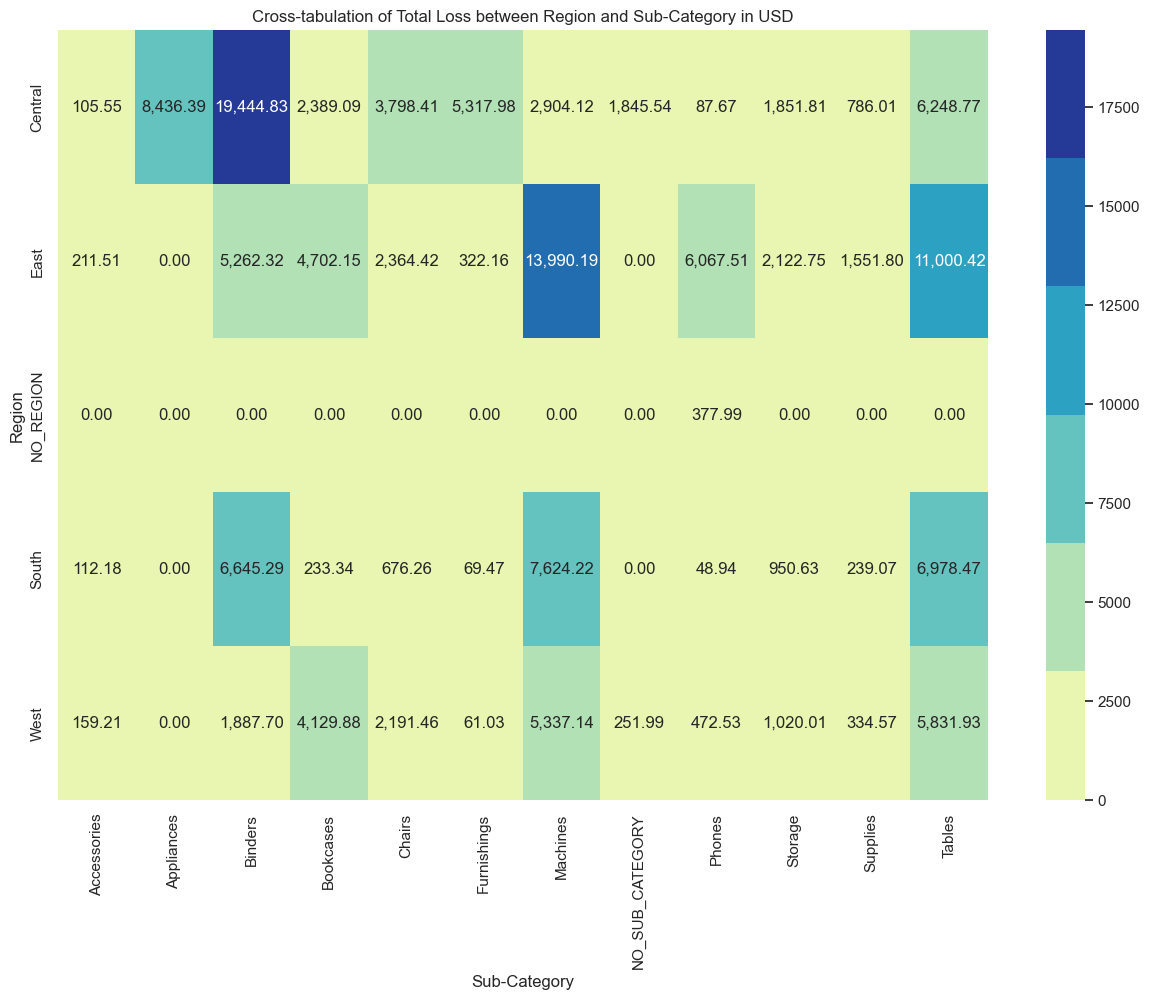

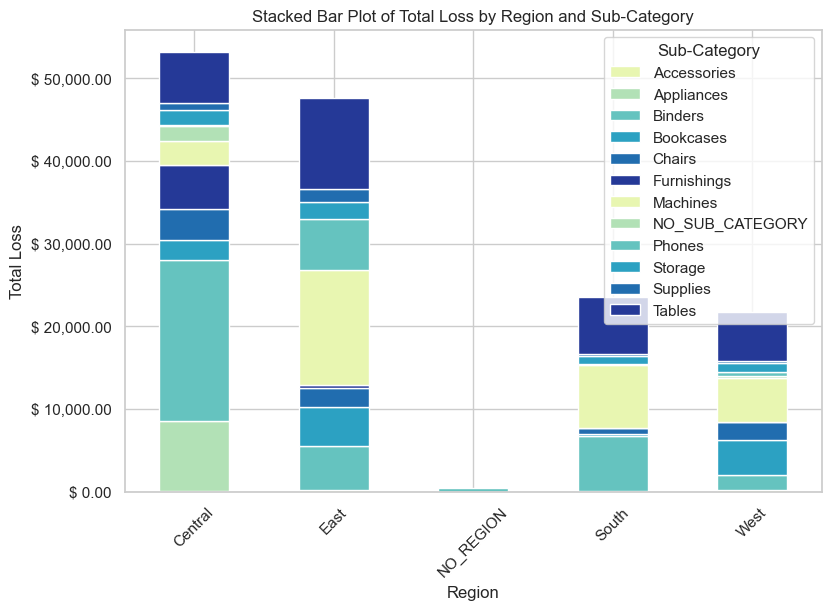

In [830]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Loss')

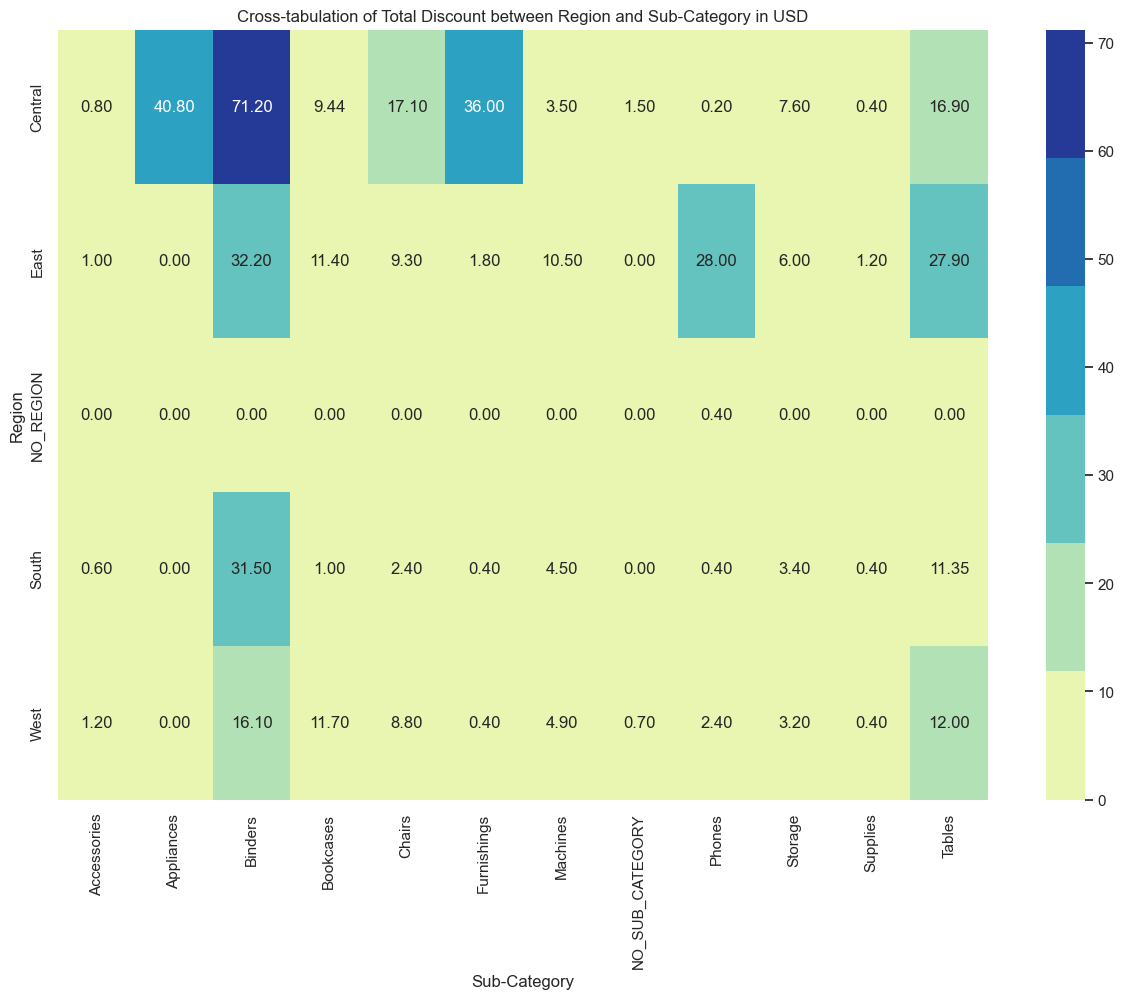

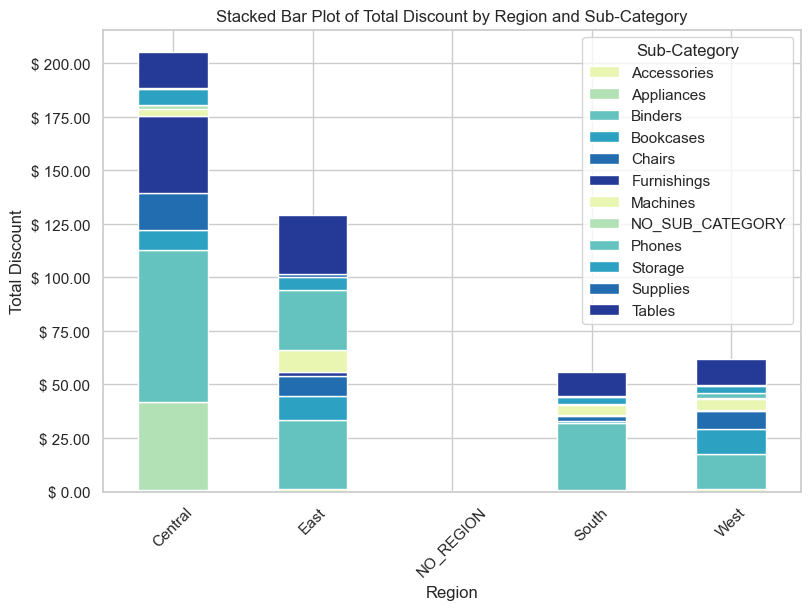

In [831]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Discount')

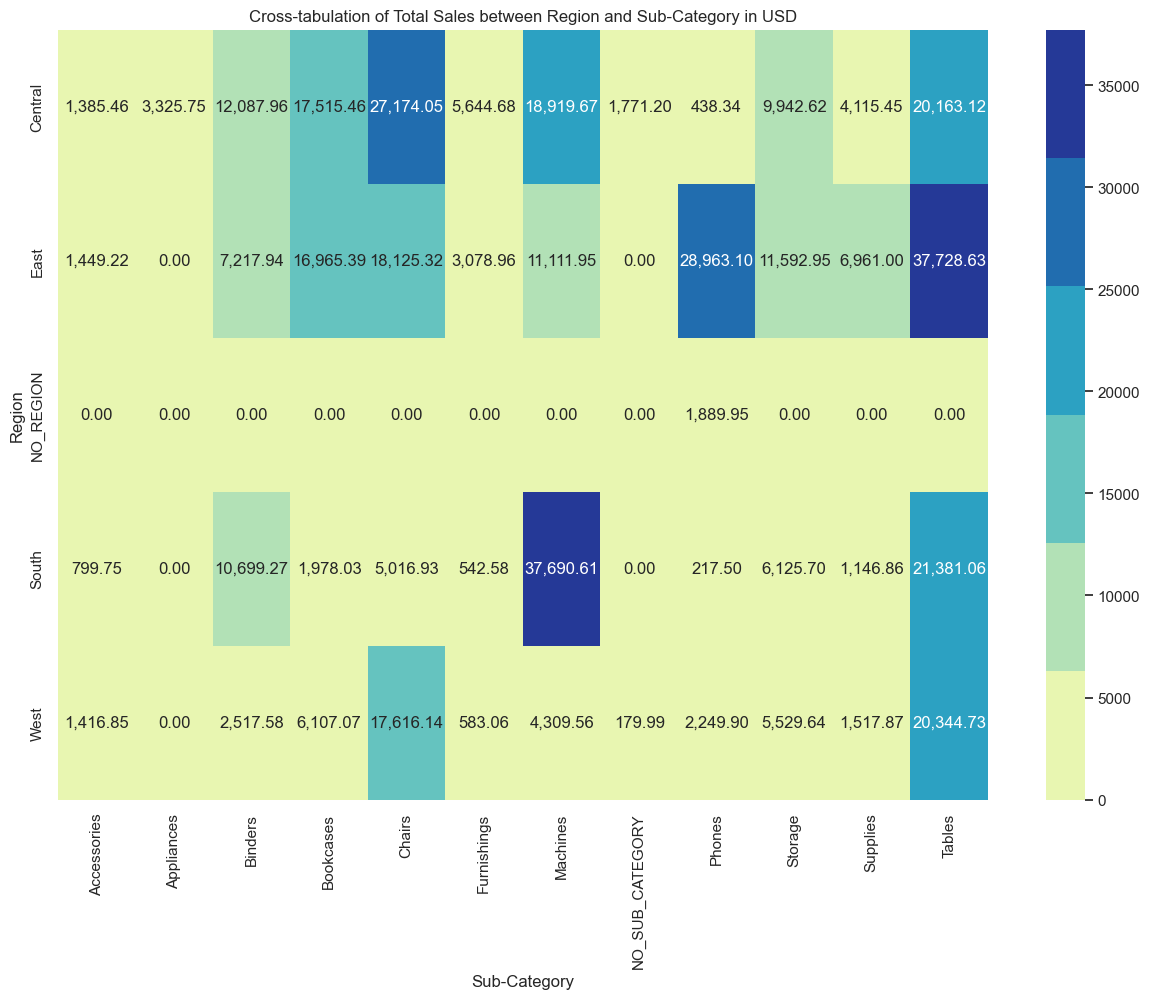

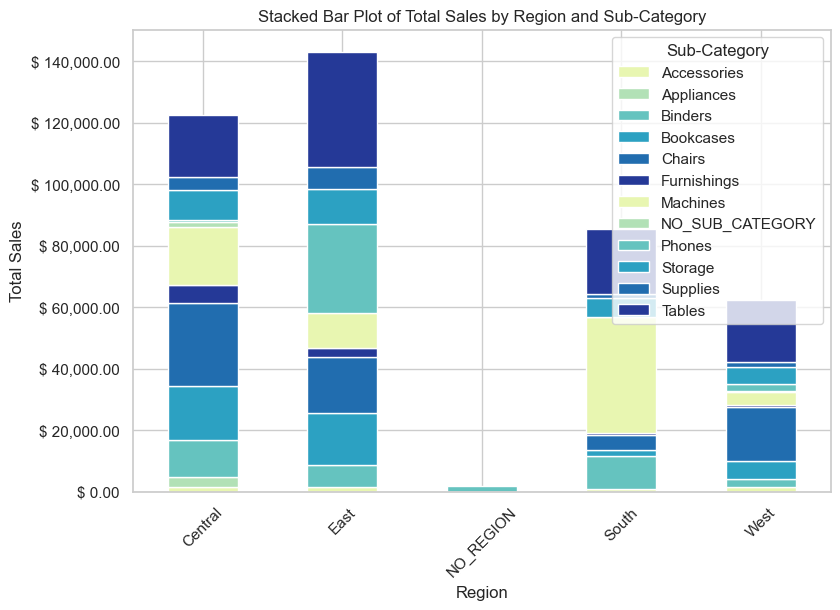

In [832]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Sales')

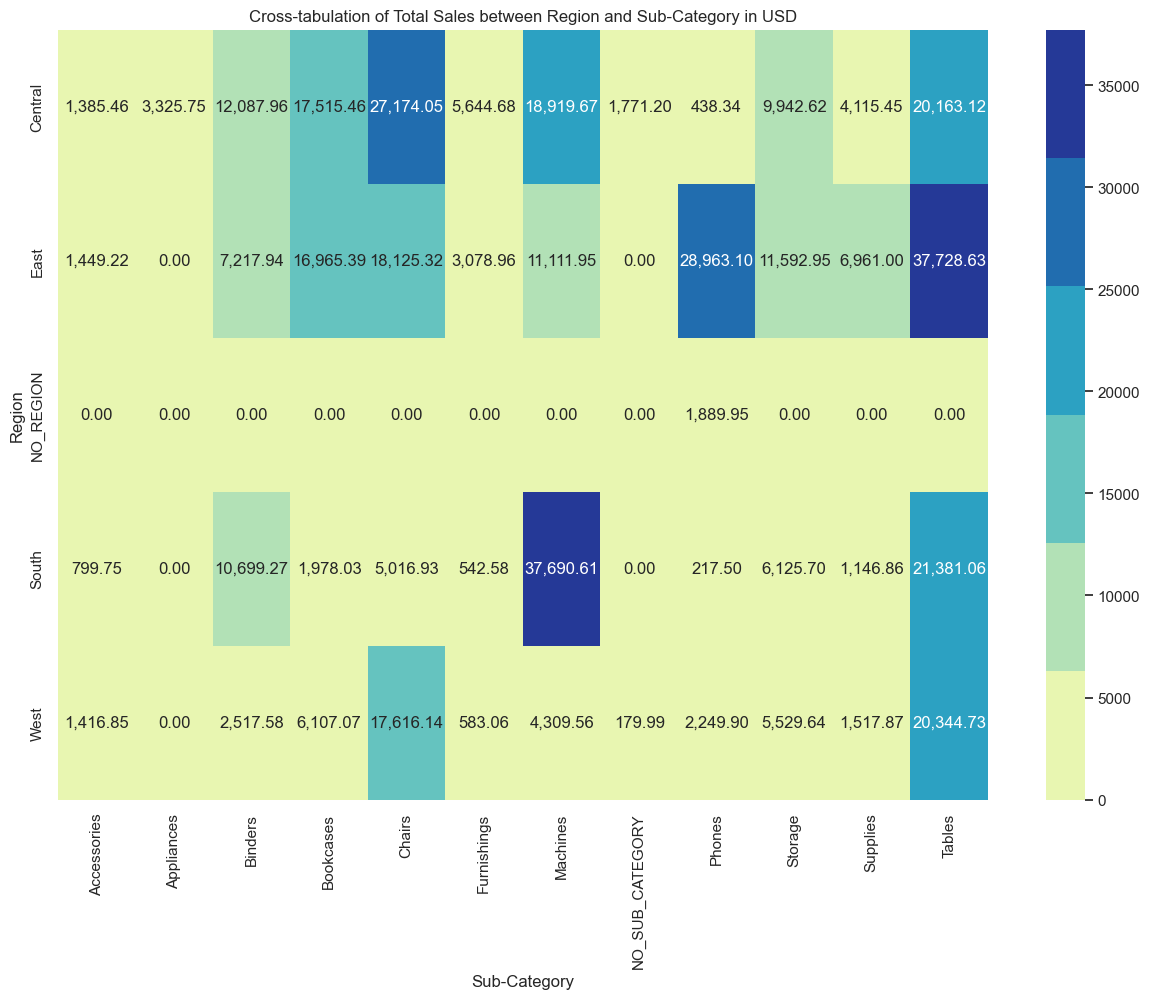

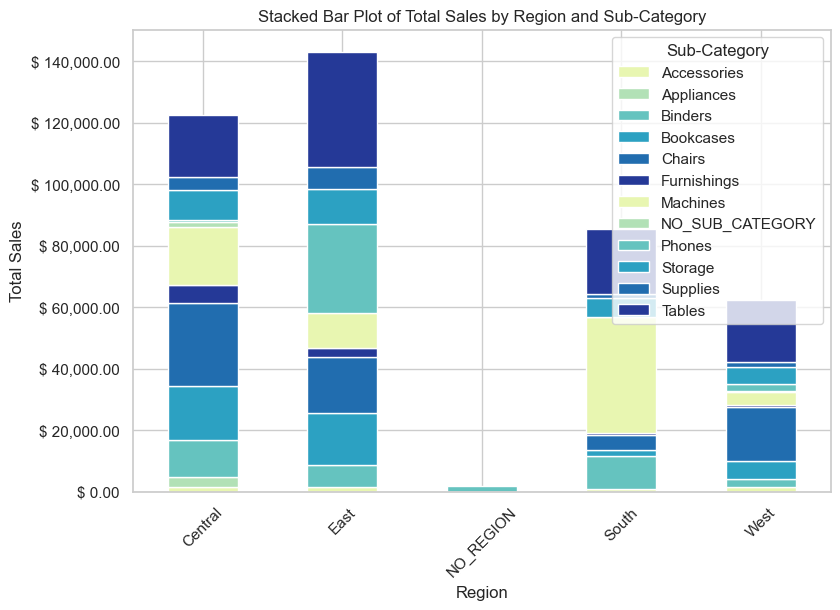

In [833]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Sales')

#### Category Vs. Sub Category

In [ ]:
#Grouping the data on category and it's respective sub-categories. Calculating the Loss margin.
sales_per_cat_subcat = global_super_store_df.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Loss']].sum()
sales_per_cat_subcat['Loss Margin'] = sales_per_cat_subcat['Loss'] / sales_per_cat_subcat['Sales']

#Sorting the dataframe based on loss margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Category', 'Sub-Category', 'Loss Margin'], ascending=True)

# Filter the DataFrame based on the desired category values
filter_categories = ['NO_CATEGORY']  # Specify the categories you want to exclude
filtered_sales_per_cat_subcat_df = sales_per_cat_subcat[~sales_per_cat_subcat['Category'].isin(filter_categories)]

# plot a loss margins sub-category bar chart 
fig, ax = plt.subplots(figsize=(15,10))

# Unique sub categories without NO_SUB_CATEGORY
unique_sub_categories_without_custom_label = sales_per_cat_subcat[sales_per_cat_subcat['Sub-Category'] != 'NO_SUB_CATEGORY']['Sub-Category'].unique()

#Plotting the loss margin per sub-category.
sns.barplot(y=filtered_sales_per_cat_subcat_df['Sub-Category'], x=filtered_sales_per_cat_subcat_df['Loss Margin'], hue=filtered_sales_per_cat_subcat_df['Category'], 
                alpha=1, dodge=False, ax=ax, order=unique_sub_categories_without_custom_label)

#Cleaning out bar junk
ax.spines['left'].set_position(('data', 0.0))
ax.spines[['right','top']].set_visible(False)
ax.set(ylabel=None, xlabel='Loss Margin (%)')

def move_ylabel_tick(index: list):
    """
    Moving the provided ylabel ticks
    """
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment('right')

#Moving the y-labels on sub-categories that are making a loss in order to prevent collision of the bar and the text.
move_ylabel_tick([-1, -2, -3])

#Annotating the loss margin amount for each bar.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f'{p.get_width()*100 :.1f}%', (p.get_width() / 2, y + 0.45))
    
#Calculating aggregate loss margin in order to compare it to each sub-category's loss margin
mean_loss = (sales_per_cat_subcat['Loss'].sum() / sales_per_cat_subcat['Sales'].sum())

#Plotting a vertical line and annotating the Superstore's aggregate loss margin.
ax.axvline(mean_loss, color='blue', label='Mean Loss, All Categories', alpha=0.75, ls='-.')
ax.text(mean_loss, ax.get_ylim()[1]*0.9, f'Mean Loss: {mean_loss * 100:.2f}%', color='blue', fontsize=12, ha='center')

#Setting the title and legend.
ax.set_title('Loss Margin by Sub-Category', fontdict={'fontsize':16})
ax.legend(loc=(1, 0.9))

#Formatting the x-axis as %
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### Numerical vs numerical

In [834]:
def bivariate_numerical_analysis(df, num_var1, num_var2):
    """
    Perform bivariate analysis and visualization between two numerical variables.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        num_var1 (str): Name of the first numerical variable.
        num_var2 (str): Name of the second numerical variable.
    """
    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=num_var1, y=num_var2, data=df)
    plt.title(f'Scatter plot of {num_var1} vs {num_var2}')
    plt.xlabel(num_var1)
    plt.ylabel(num_var2)
    plt.show()
    
    # Correlation matrix
    corr_matrix = df[[num_var1, num_var2]].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

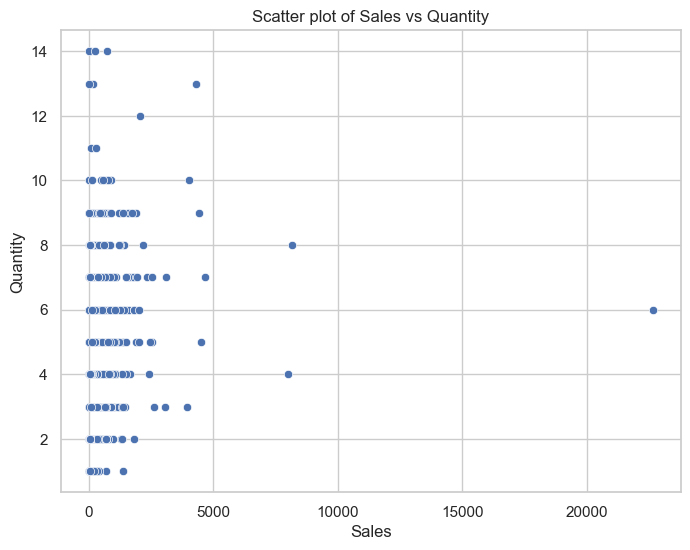

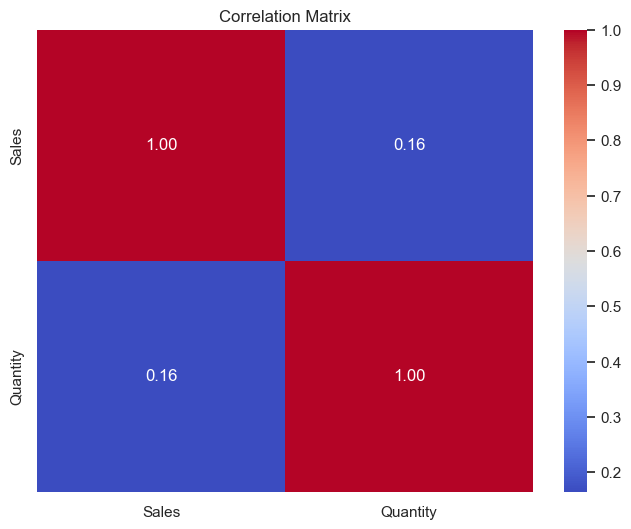

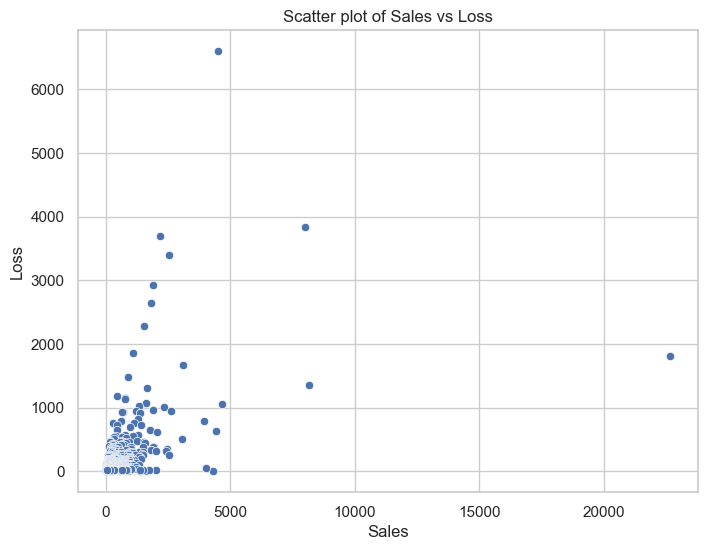

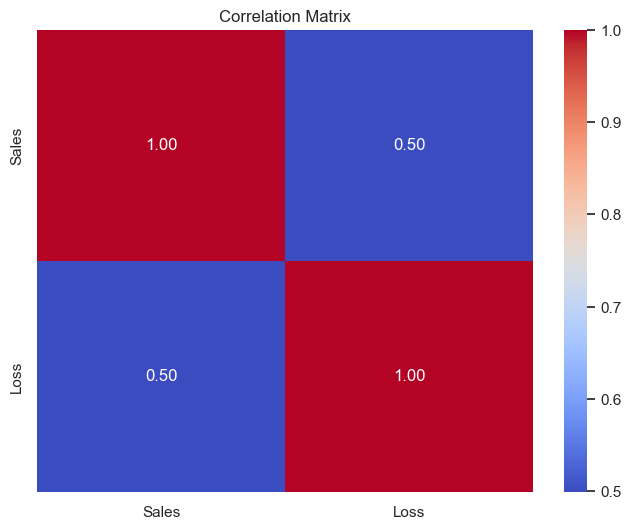

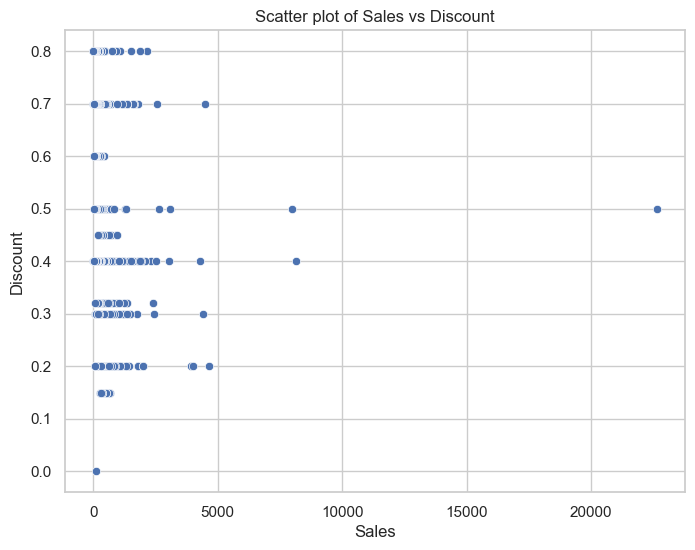

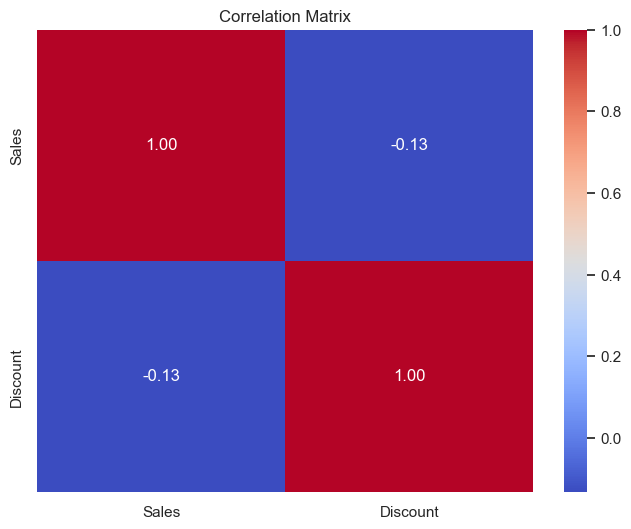

In [835]:
bivariate_numerical_analysis(global_super_store_df, 'Sales', 'Quantity')
bivariate_numerical_analysis(global_super_store_df, 'Sales', 'Loss')
bivariate_numerical_analysis(global_super_store_df, 'Sales', 'Discount')

### Categorical vs numerical

In [840]:
# Bivariate analysis and visualization
def bivariate_analysis_categorical_numerical(df, cat_var, num_var):
    # Box plot to visualize the distribution of the numerical variable for each category
    plt.figure(figsize=(15, 10))
    sns.boxplot(x=cat_var, y=num_var, data=df)
    plt.title(f'Boxplot of {num_var} by {cat_var}')
    plt.xlabel(cat_var)
    plt.ylabel(num_var)
    plt.show()

    # Violin plot to visualize the distribution of the numerical variable for each category
    plt.figure(figsize=(15, 10))
    sns.violinplot(x=cat_var, y=num_var, data=df)
    plt.title(f'Violinplot of {num_var} by {cat_var}')
    plt.xlabel(cat_var)
    plt.ylabel(num_var)
    plt.show()

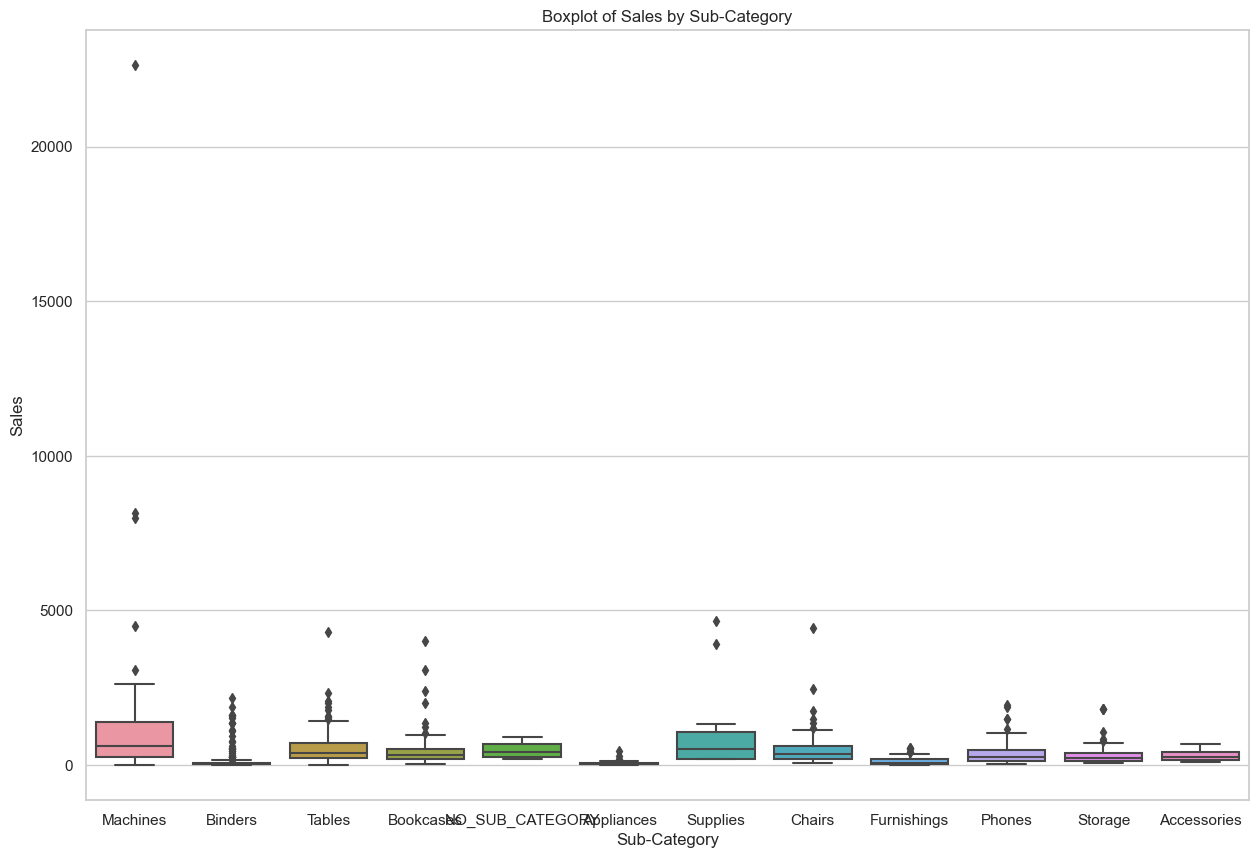

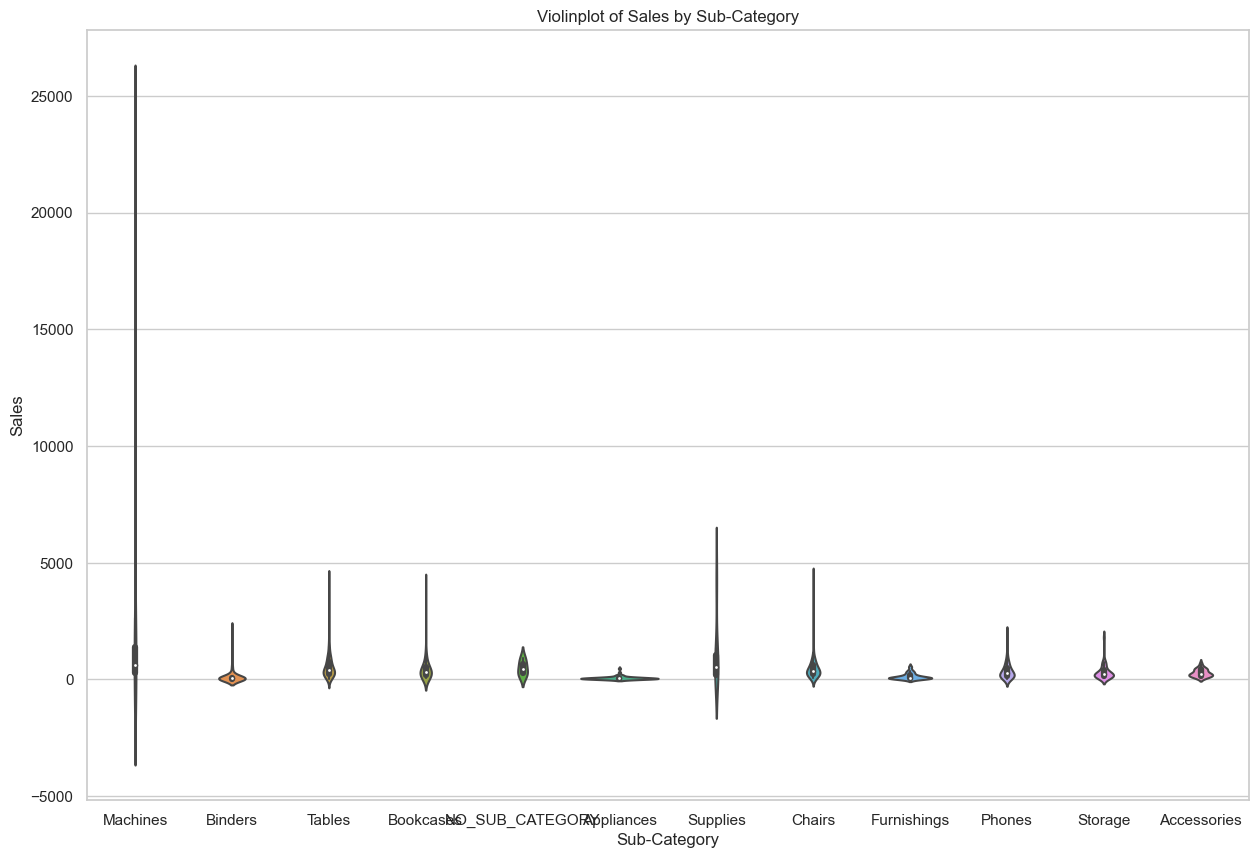

In [841]:
# Call the function for bivariate analysis
bivariate_analysis_categorical_numerical(global_super_store_df, 'Sub-Category', 'Sales')

#### Geo Analysis

In [ ]:
def geo_analysis_by_state(df, feature_column):
    """
    geo_analysis_by_state, plots the feature percentages on a US map grouped by States

    Args:
    - df (DataFrame): DataFrame containing the feature data.
    - feature_column (str): Name of the numerical feature column.

    Returns:
    - None
    """
    
    base_folder_path = os.getcwd()
    shp_path = '/data/usa-states-census-2014.shp'

    us_states = gpd.read_file(f'{base_folder_path}{shp_path}')
    us_states = us_states.to_crs("EPSG:3395")

    # Group feature data based on States
    feature_per_states = df.groupby(['State'], as_index=False)[[feature_column]].sum()

    # Create a new column to see the Feature %
    feature_percent_column_name = feature_column + ' %'

    # Calculate the sum of the feature_column
    total_feature_sum = df[feature_column].sum()

    # Check if the total sum is zero
    if total_feature_sum == 0:
        # If the total sum is zero, set all percentages to zero or handle the scenario according to your specific requirements
        feature_per_states[feature_percent_column_name] = 0
    else:
        # Calculate percentages only if the total sum is not zero
        feature_per_states[feature_percent_column_name] = (feature_per_states[feature_column] / total_feature_sum) * 100

    # Merge sales data with the US map based on state codes or names
    merged_data = us_states.merge(feature_per_states, how='left', left_on='NAME', right_on='State')

    # Filter out duplicate entries
    merged_data = merged_data.drop_duplicates(subset=['NAME'])

    # Fill NaN values with 0 for the percentage column
    merged_data[feature_percent_column_name].fillna(0, inplace=True)

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(30, 10))
    us_states.plot(ax=ax, color='lightgrey', edgecolor='black')
    merged_data.plot(column=feature_percent_column_name, cmap='Spectral_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, aspect='equal')

    # Annotate state names and sales percentages
    texts = []
    for idx, row in merged_data.iterrows():
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        name = row['NAME']
        feature_percent = row[feature_percent_column_name]
        text = ax.text(x, y, name, fontsize=9, ha='center', va='center', color='black')
        texts.append(text)
        text = ax.text(x, y-0.5, f"{feature_percent:.2f}%", fontsize=9, ha='center', va='center', color='black')  # Adjust y position
        texts.append(text)

    # Adjust text labels to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

    ax.axis('off')
    ax.set_title(f'{feature_column} percent by US State', loc='center', fontsize=20, y=1.0)
    plt.show()

##### Sales % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Sales')

##### Quantity % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Quantity')

##### Loss % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Loss')

##### Discount % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Discount')

* Sales conclusion:
    * **Texas** has the most percentage of Sales with ~22%.
    * The Central and South regions of the country collectively could not match the sales numbers of Texas.

* Losses conclusion:
    * **Texas** despite of making ~22% of Sales, has grossed an ~24% of losses.

* Discounts conclusion:
    * **Texas** order has nearly nearly ~29% discounts in Total.

### Conculsion

#### Geo Analysis Conclusion